In [1]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor
from category_encoders import TargetEncoder

In [2]:
df = pd.read_csv("historical_data.csv")

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
#If actual_delivery_time is missing, you can’t compute the delivery duration, making the row unusable for supervised learning.
critical_columns = [
    'market_id',
    'actual_delivery_time'
]

# Removing rows with null values in the above-mentioned attributes or columns
df = df.dropna(subset=critical_columns)

In [5]:
#  Convert timestamps and create target variable (delivery_duration in minutes)
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()/60

In [6]:
### Pre-Processing

# 1. Drop rows with critical missing values
df.dropna(subset=[
    'total_onshift_dashers', 'total_busy_dashers',
    'total_outstanding_orders', 'store_primary_category',
    'estimated_store_to_consumer_driving_duration', 'actual_delivery_time'
], inplace=True)

# 2. Target Encoding columns
te = TargetEncoder()
df['store_primary_category_encoded'] = te.fit_transform(df['store_primary_category'], df['delivery_duration'])
df['store_id'] = df['store_id'].astype(str)
df['store_id_encoded'] = te.fit_transform(df['store_id'], df['delivery_duration'])

# 3. One Hot Encoding columns
df = pd.get_dummies(df, columns=['market_id', 'order_protocol'], drop_first=True)

In [7]:
# STEP 4: Select Features 
# -----------------------------
features = [
    'store_id_encoded', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0',
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
    'store_primary_category_encoded',
]

df_v1 = df[features + ['delivery_duration']].dropna()

In [8]:
# STEP 5: Define X and y
# -----------------------------
X = df_v1[features]
y = df_v1['delivery_duration']

In [9]:
#STEP 6: Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# STEP 7: Define Models
# -----------------------------
models_v1 = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(n_estimators=30, max_depth=8, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=30, max_depth=4, learning_rate=0.1, random_state=42)
}

In [10]:
# STEP 8: Evaluation Function
# -----------------------------
def evaluate_model(y_true, y_pred):
    return {
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'RMSE': round(root_mean_squared_error(y_true, y_pred)),
        'R²': round(r2_score(y_true, y_pred), 4)
    }

In [42]:
# STEP 9: Train and Evaluate Each Model
# -----------------------------
results_v1 = {}
for name, model in models_v1.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_v1[name] = evaluate_model(y_test, y_pred)

# -----------------------------
# STEP 10: View Results
# -----------------------------
import pprint
print("Data Pre-Processing V1 Results:")
pprint.pprint(results_v1)

Data Pre-Processing V1 Results:
{'Linear': {'MAE': 11.3, 'RMSE': 47, 'R²': 0.0633},
 'Random Forest': {'MAE': 11.64, 'RMSE': 47, 'R²': 0.0466},
 'Ridge': {'MAE': 11.3, 'RMSE': 47, 'R²': 0.0633},
 'XGBoost': {'MAE': 11.61, 'RMSE': 47, 'R²': 0.0449}}


C:\Users\deepa\AppData\Local\Temp\ipykernel_18096\2153969342.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


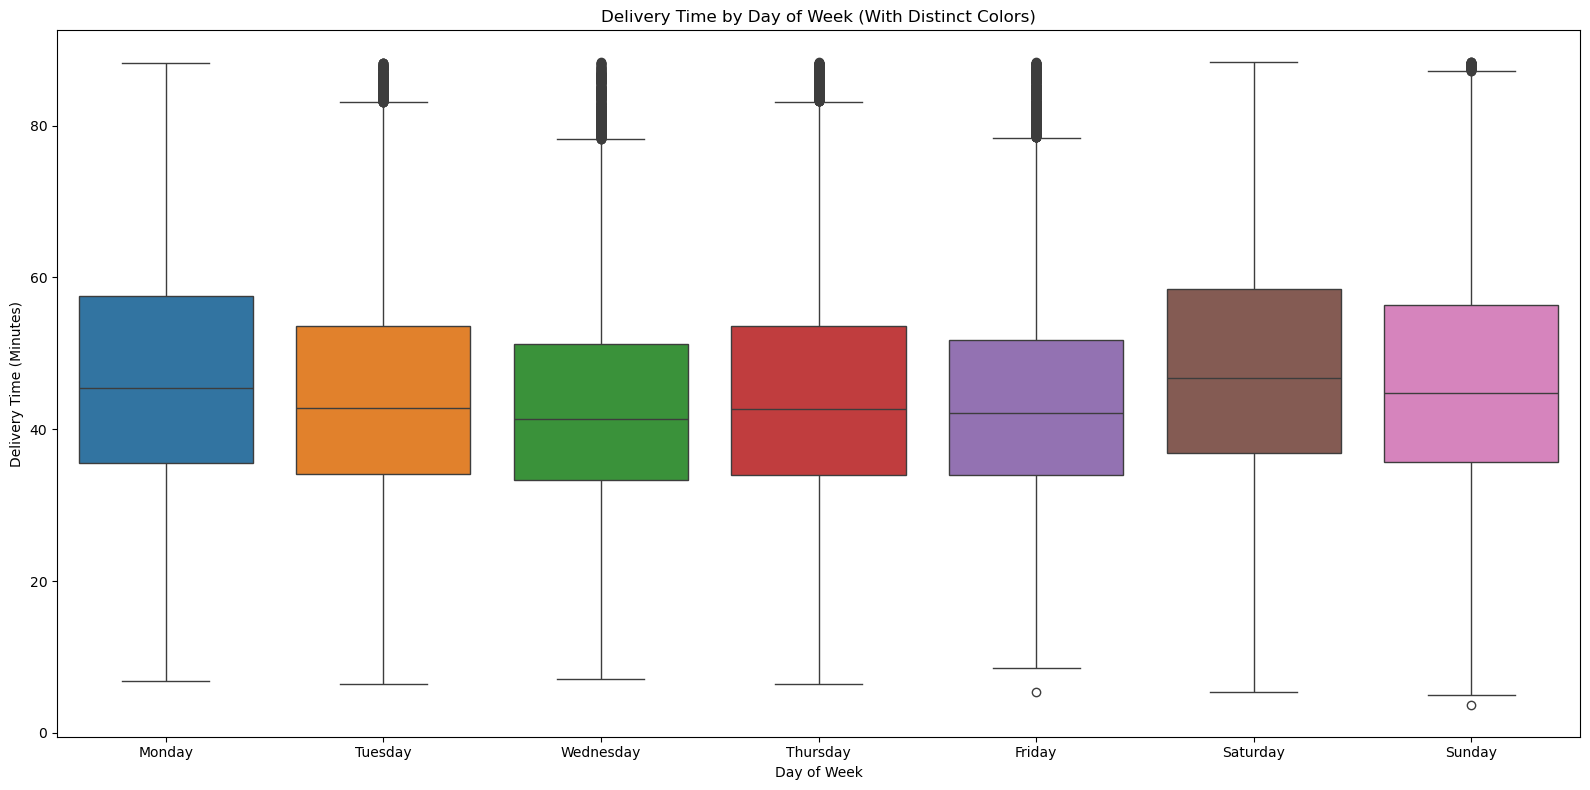

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copy your DataFrame
dd_df_master2 = df.copy()

# Ensure 'delivery_time' is numeric
dd_df_master2['delivery_duration'] = pd.to_numeric(dd_df_master2['delivery_duration'], errors='coerce')

# Extract day names if not already present
if 'day_of_week_name' not in dd_df_master2.columns and 'created_at' in dd_df_master2.columns:
    dd_df_master2['created_at'] = pd.to_datetime(dd_df_master2['created_at'], errors='coerce')
    dd_df_master2['day_of_week_name'] = dd_df_master2['created_at'].dt.day_name()

# Outlier removal using IQR
Q1 = dd_df_master2['delivery_duration'].quantile(0.25)
Q3 = dd_df_master2['delivery_duration'].quantile(0.75)
IQR = Q3 - Q1
filtered_df = dd_df_master2[
    (dd_df_master2['delivery_duration'] >= Q1 - 1.5 * IQR) &
    (dd_df_master2['delivery_duration'] <= Q3 + 1.5 * IQR)
]

# Define a color palette (1 color per day)
day_palette = {
    'Monday': '#1f77b4',
    'Tuesday': '#ff7f0e',
    'Wednesday': '#2ca02c',
    'Thursday': '#d62728',
    'Friday': '#9467bd',
    'Saturday': '#8c564b',
    'Sunday': '#e377c2'
}

# Plot
plt.figure(figsize=(16, 8))
sns.boxplot(
    x='day_of_week_name',
    y='delivery_duration',
    data=filtered_df,
    palette=day_palette,
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.title("Delivery Time by Day of Week (With Distinct Colors)")
plt.xlabel("Day of Week")
plt.ylabel("Delivery Time (Minutes)")
plt.tight_layout()
plt.savefig("delivery_duration_by_day.png", dpi=300)  # Save as PNG with high resolution
plt.show()

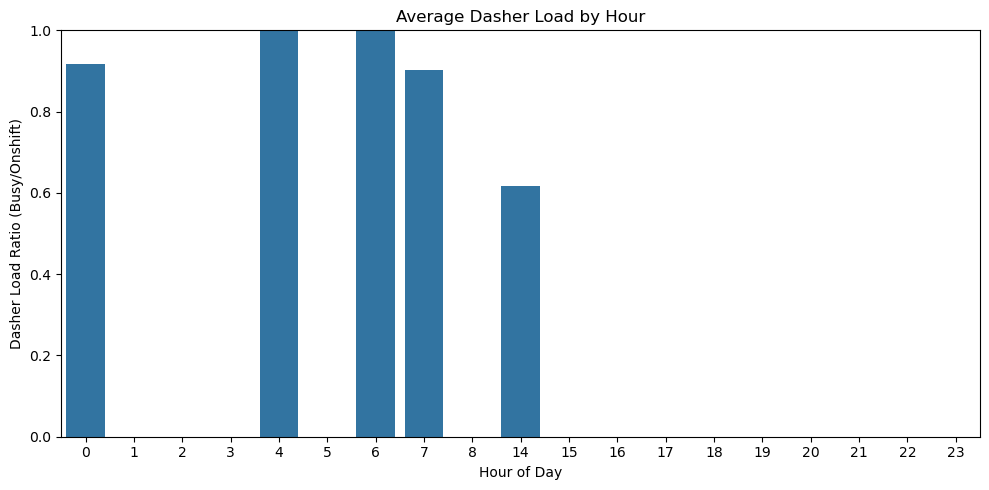

In [13]:
df['dasher_load'] = df['total_busy_dashers'] / df['total_onshift_dashers']
df['hour'] = df['created_at'].dt.hour
load_by_hour = df.groupby('hour')['dasher_load'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=load_by_hour.index, y=load_by_hour.values)
plt.title("Average Dasher Load by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Dasher Load Ratio (Busy/Onshift)")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("AverageDasher.png", dpi=300)  # Save as PNG with high resolution
plt.show()

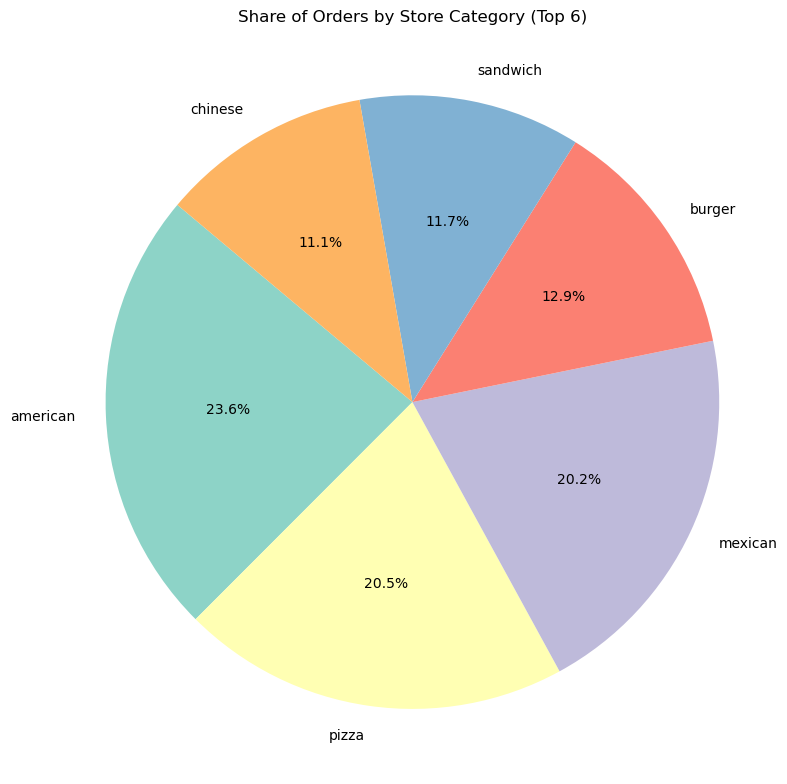

In [14]:
# Prepare data
store_counts = df['store_primary_category'].value_counts().nlargest(6)

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    store_counts.values,
    labels=store_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title("Share of Orders by Store Category (Top 6)")
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.tight_layout()
plt.savefig("Orders.png", dpi=300)  # Save as PNG with high resolution
plt.show()

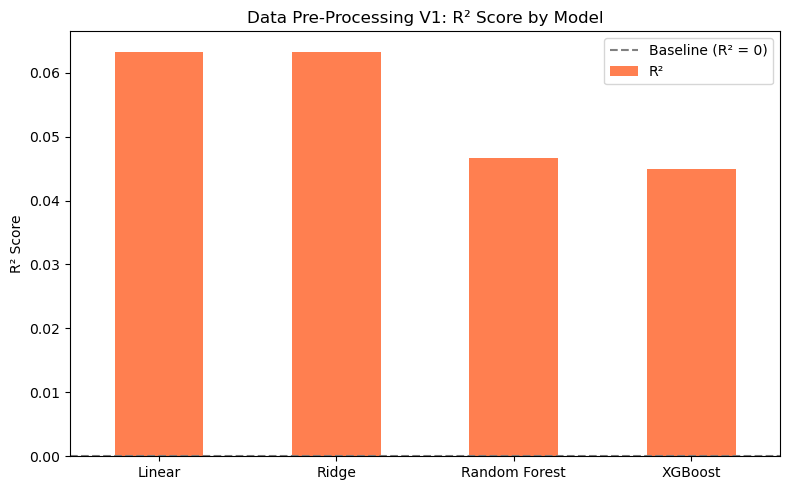

In [38]:
df_v1_results = pd.DataFrame(results_v1).T  # Transpose to get models as rows
df_v1_results['R²'].plot(kind='bar', color='coral', figsize=(8, 5))
plt.title("Data Pre-Processing V1: R² Score by Model")
plt.ylabel("R² Score")
plt.xticks(rotation=0)
plt.axhline(0, color='gray', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.tight_layout()
plt.savefig("Results.png", dpi=300)  # Save as PNG with high resolution
plt.show()

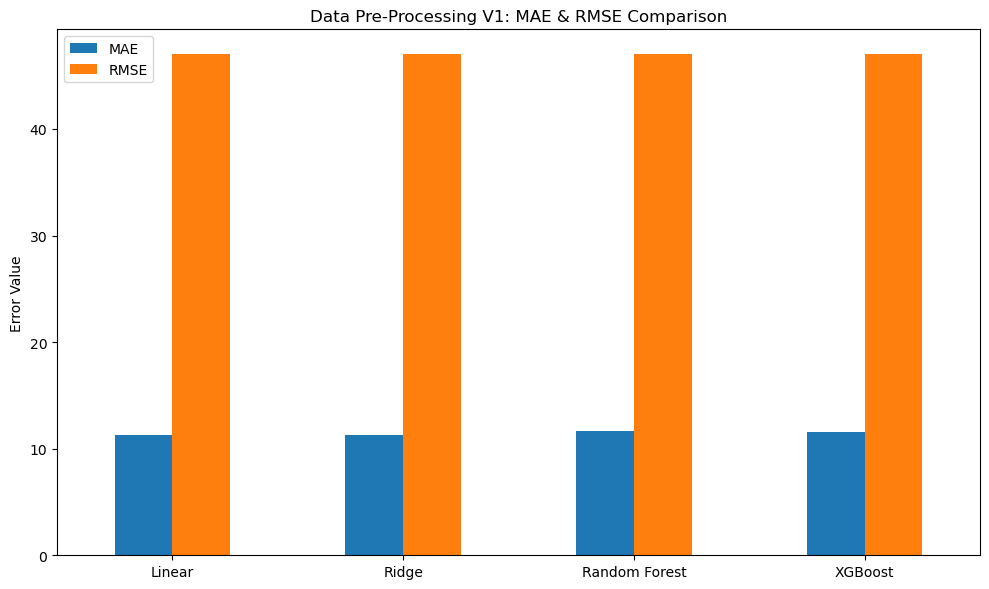

In [39]:
df_v1_results = pd.DataFrame(results_v1).T  # Transpose to get models as rows
df_v1_results[['MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title("Data Pre-Processing V1: MAE & RMSE Comparison")
plt.ylabel("Error Value")
plt.xticks(rotation=0)
#plt.grid(axis='y')
plt.tight_layout()
plt.savefig("MAE.png", dpi=300) 
plt.show()